# Finite potential Well

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(E, V):
    return np.sqrt(E) * np.tan(2 * np.arctan(np.sqrt(E) / (np.sqrt(V) + np.sqrt(V - E))) + np.sqrt(E) + 0.5 * np.pi) - np.sqrt(V - E)

In [3]:
Erange = np.linspace(1e-3, 100, 10000)
V = 100
fun = f(Erange, V)

Text(0.5, 0, 'Energy with a potential of V=100')

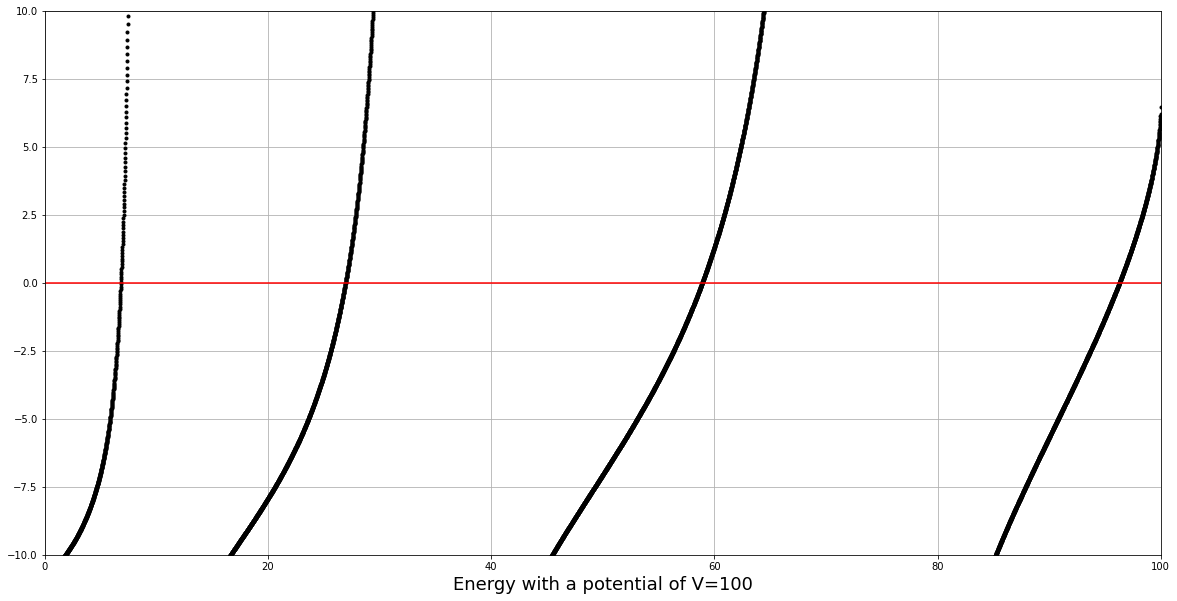

In [4]:
plt.figure(figsize=(20,10))
plt.plot(Erange, fun, 'k.')
plt.xlim([0, 100])
plt.ylim([-10, 10])
plt.grid()
plt.axhline(0, c='r')
plt.xlabel(f'Energy with a potential of V={V}', fontsize=18)

# Torus

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation

In [6]:
def slater(x, k):
    n = len(k)
    xx, kk = np.meshgrid(x, k)
    S = np.exp(1j * xx * kk)
    return S.T

def psi(x, k):
    S = slater(x, k)
    return 1 / np.sqrt(math.factorial(x.size)) * np.linalg.det(S)

def get_k(N, L):
    return np.array([2 * np.pi / L * (i + (N-1)/2) for i in range(1, N+1)])

In [7]:
gridsize = 100
x = np.linspace(0, 1, gridsize)
y = np.linspace(0, 1, gridsize)
xx, yy = np.meshgrid(x, y)
phi = 2 * np.pi * xx
theta = 2 * np.pi * yy
R = 1.5 # whole donut radius
r = 0.55 # radius of the donut's mass
surfacex = np.cos(theta) * (R + r * np.cos(phi))
surfacey = np.sin(theta) * (R + r * np.cos(phi))
surfacez = r * np.sin(phi)

In [8]:
k = get_k(2, 1)
Z = np.empty((gridsize, gridsize))
for i in tqdm(range(gridsize), total=gridsize):
    for j in range(gridsize):
        p = np.abs(psi(np.array([x[i], y[j]]), k))**2
        Z[i, j] = p

100%|██████████| 100/100 [00:00<00:00, 145.52it/s]


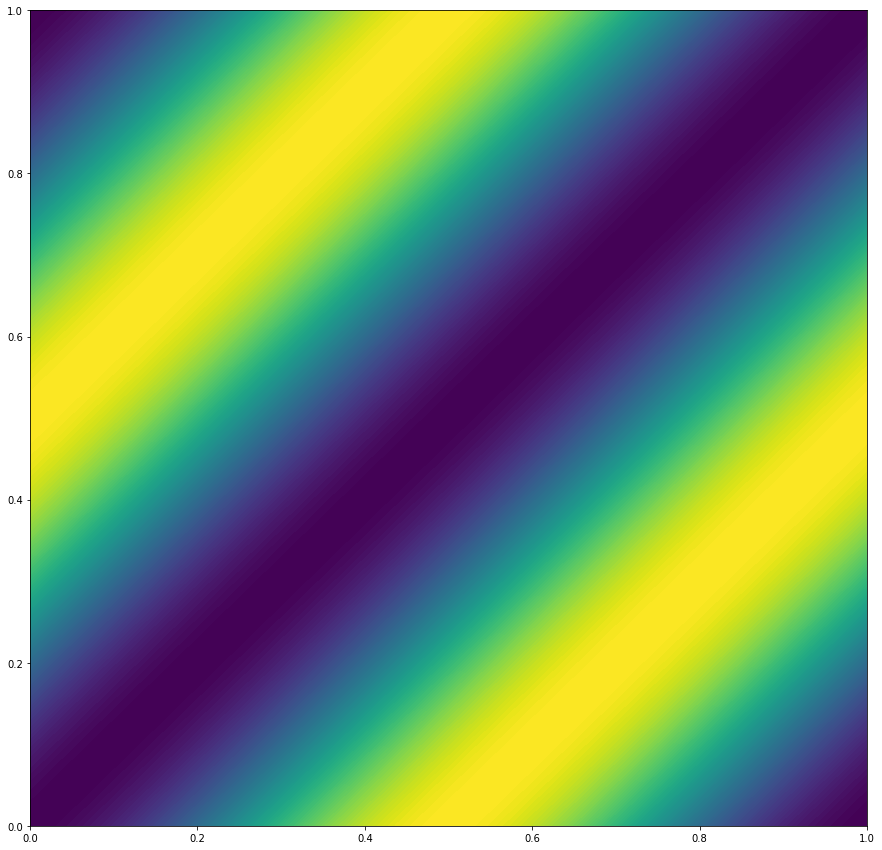

In [9]:
plt.figure(figsize=(15, 15))
plt.contourf(xx, yy, Z, levels=100);

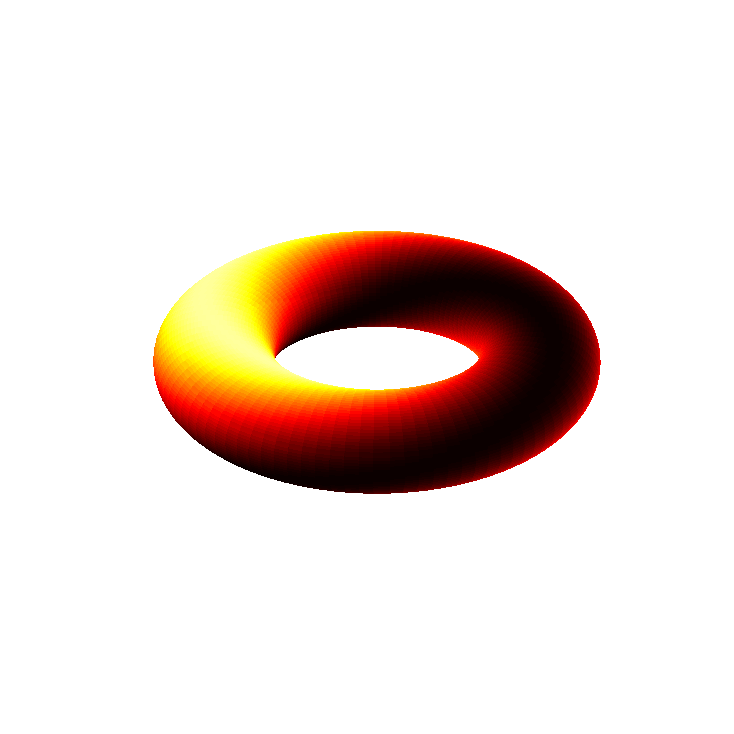

In [10]:
scaler = MinMaxScaler(feature_range=(0, 0.9))

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot_surface(surfacex, surfacey, surfacez, facecolors=plt.cm.hot(scaler.fit_transform(Z)), antialiased=False, rstride=1, cstride=1, vmin=-1, vmax=2, shade=False)
lim = (max(abs(max(np.max(surfacex), np.max(surfacey), np.max(surfacez))), abs(min(np.min(surfacex), np.min(surfacey), np.min(surfacez)))))
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
plt.axis('off')

def rotate(angle):
     ax.view_init(azim=angle)
        
angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('torus_wavefunc.gif', writer=animation.PillowWriter(fps=20))

# The data!

In [2]:
from train_GMM import get_points_in_box
import tensorflow as tf
import sys
sys.path.append("../DMAE")
sys.path.append("../DMAE/examples/synthetic")
import DMAE
import vis_utils
import itertools

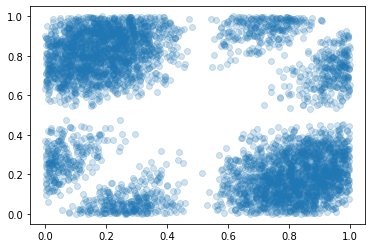

In [3]:
X = np.load("particle_positions_N=3_metro_steps=1000000_last_fixed.npz").T
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx][:5000]
X = get_points_in_box(X, 1)

X = np.float32(X[:, :2])
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)

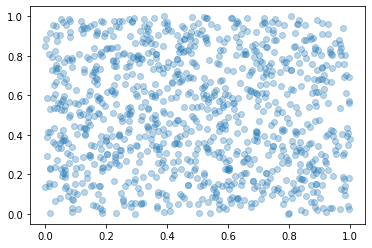

In [4]:
# Noise

Xp = np.random.rand(1000, 2)
plt.scatter(*Xp.T, alpha=0.3)

In [5]:
def min_dist(xi, Y):
    d = np.sum((xi - Y)**2, axis=1)
    return np.min(d)

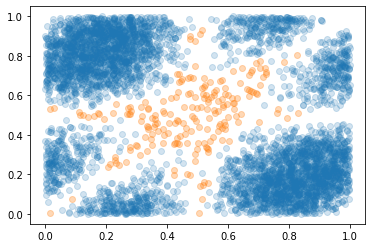

In [6]:
md = np.apply_along_axis(lambda xi: min_dist(xi, X), 1, Xp)
p = np.percentile(md, 80, interpolation='lower')
plt.scatter(*X.T, alpha=0.2)
plt.scatter(*Xp[md >= p].T, alpha=0.3)

In [7]:
# Number of clusters
n_clusters = 2
# Softmax inverse temperature parameter
alpha = 50
# Training parameters
batch_size = 256
epochs = 200
lr = 1e-4

In [8]:
def toroidal_dis(x_i, Y, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((x_i-Y+delta)**2, axis=1), d)
    return d

def toroidal_pairwise(X, Y, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_dis(x_i, Y, interval)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_loss(X, mu_tilde, pi_tilde, alpha, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((X-mu_tilde+delta)**2, axis=1), d)
    return tf.reduce_sum(d-tf.math.log(pi_tilde)/alpha)

In [9]:
interval = tf.constant((1.0, 1.0))
dis = lambda X, Y: toroidal_pairwise(X, Y, interval)
dmae_loss = lambda X, mu_tilde, pi_tilde, alpha: toroidal_loss(X, mu_tilde, pi_tilde, alpha, interval)

In [10]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 50),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
loss = dmae_loss(inp, *theta_tilde, alpha)
model.add_loss(loss)
model.compile(optimizer=tf.optimizers.Adam(lr=lr))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
model.fit(X, X, epochs=epochs, batch_size=batch_size)

Epoch 1/200
20/20 [==============================] - 0s 2ms/step - loss: 13.4842
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 13.3324
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 13.1853
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 13.0418
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 12.9021
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 12.7683
Epoch 7/200
20/20 [==============================] - 0s 3ms/step - loss: 12.6371
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 12.5100
Epoch 9/200
20/20 [==============================] - 0s 1ms/step - loss: 12.3828
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 12.2550
Epoch 11/200
20/20 [==============================] - 0s 4ms/step - loss: 12.1271
Epoch 12/200
20/20 [==============================] - 0s 2ms/step - loss: 12.0017
Epoch 13/200
20/20 [=====

In [12]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoder(alpha=0.1, n_clusters=n_clusters,
                                                  dissimilarity=dis,
                                                  trainable={"centers": False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(0.0, 1.0)

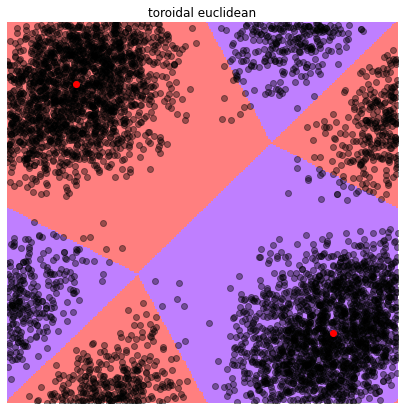

In [13]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal euclidean", X, (7, 7), batch_size)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

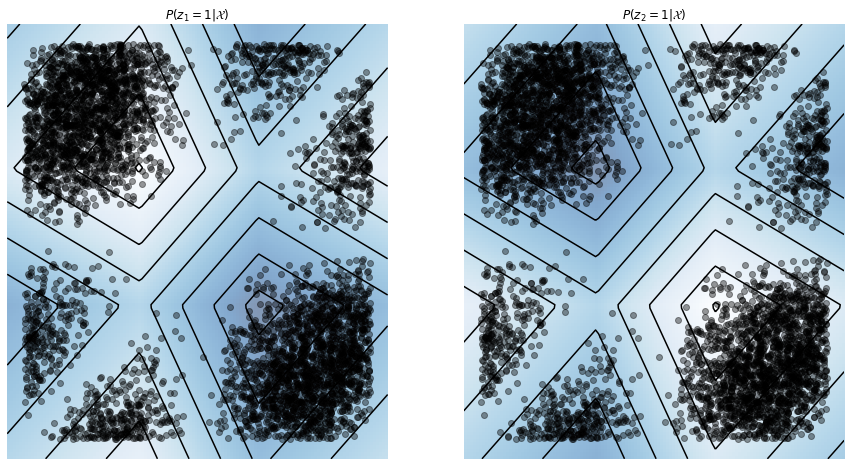

In [14]:
fig, ax = vis_utils.visualize_probas(DMAE_encoder, X, n_clusters, rows=1, cols=2, figsize=(15, 8))

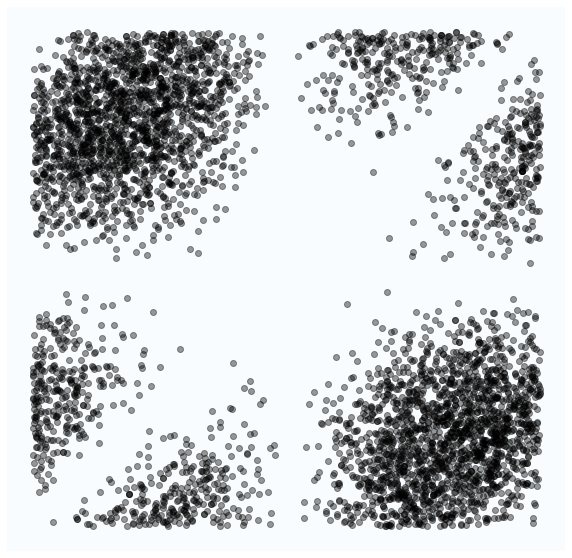

In [14]:
fig, ax = vis_utils.visualize_distribution(model, toroidal_loss, alpha, X, encoder=DMAE_encoder, cov=False, figsize=(10, 10))

### Now, with covariances

In [15]:
import tensorflow_probability as tfp

def toroidal_mahalanobis(x_i, Y, cov, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(x_i-Y+delta, axis=-1)
        d = tf.minimum(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff)*diff, axis=1)), d)
    return d

def toroidal_mahalanobis_pairwise(X, Y, cov, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_mahalanobis(x_i, Y, cov, interval)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_mahalanobis_loss(X, mu_tilde, Cov_tilde, pi_tilde, alpha, interval=tf.constant((1.0, 1.0))):
    mu_tilde = tf.math.floormod(mu_tilde, interval)
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(X-mu_tilde+delta, axis=1)
        d = tf.minimum(tf.squeeze(tf.matmul(tf.matmul(diff, Cov_tilde), tf.transpose(diff, perm = [0, 2, 1]))), d)
    return tf.reduce_sum(d-tf.math.log(pi_tilde)/alpha)

def negative_loss(X, Xp, mu_tilde, Cov_tilde, pi_tilde, beta, interval=tf.constant((1.0, 1.0))):
    return -toroidal_mahalanobis_loss(Xp[:tf.shape(X)[0]], mu_tilde, Cov_tilde, pi_tilde, beta, interval)

In [16]:
dis = lambda X, Y, cov: toroidal_mahalanobis_pairwise(X, Y, cov, interval)
dmae_loss = lambda X, theta, alpha: toroidal_mahalanobis_loss(X, *theta, alpha, interval)
#dmae_neg_loss = lambda X, theta, beta: negative_mahalanobis_loss(X, *theta, beta, interval)
#dmae_neg_loss = lambda X, theta, beta: negative_toroidal_loss(X, *theta, beta, interval)
dmae_neg_loss = lambda X, theta, beta: negative_loss(X, tf.constant(Xp, dtype=tf.float32), *theta, beta, interval)

In [17]:
class InitIdentityCovCustom(tf.keras.initializers.Initializer):
    """
    A tf.keras initializer to assign identity matrices to covariances in DMAE.
    
    Arguments:
        X: array-like, shape=(n_samples, n_features)
            Input data.
        n_clusters: int
            Number of clusters.
    """
    
    def __init__(self, X, n_clusters, size=1.0):
        self.__X = X
        self.__n_clusters = n_clusters
        self.__size = size
    
    def __call__(self, shape, dtype):
        return self.__size * tf.eye(self.__X.shape[1], batch_shape=[self.__n_clusters])

In [18]:
alpha = 30
beta = 100000
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha=alpha, n_clusters=n_clusters,
                                                             initializers={"centers": tf.keras.initializers.RandomUniform(-1, 1),
                                                                           "cov": InitIdentityCovCustom(X, n_clusters, 0.1),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             trainable = {"centers": True, "mixers": False, "cov": True},
                                                             regularizers={"centers": None, "cov": tf.keras.regularizers.l1(1e-1), "mixers": None},
                                                             dissimilarity=dis)(inp)
# DMAE model
model2 = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
loss = dmae_loss(inp, theta_tilde, alpha)
loss2 = dmae_neg_loss(inp, theta_tilde, beta)
model2.add_loss(loss)
#model2.add_loss(loss2)
model2.compile(optimizer=tf.optimizers.Adam(lr=5e-4))
print(model2.layers[1].get_weights())

init_means = model.layers[1].get_weights()[0]
original_params = model2.layers[1].get_weights()
model2.layers[1].set_weights([init_means, *original_params[1:]])

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[array([[0.46660614, 0.48181581],
       [0.7530067 , 0.323354  ]], dtype=float32), array([[[0.1, 0. ],
        [0. , 0.1]],

       [[0.1, 0. ],
        [0. , 0.1]]], dtype=float32), array([[1., 1.]], dtype=float32)]


In [19]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=30, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
model2.fit(X, epochs=1000, batch_size=batch_size, callbacks=[callback])

Epoch 1/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.5114
Epoch 2/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3639
Epoch 3/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.2356
Epoch 4/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.1476
Epoch 5/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1096
Epoch 6/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.1247
Epoch 7/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1745
Epoch 8/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.2501
Epoch 9/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.3470
Epoch 10/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4550
Epoch 11/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.5590
Epoch 12/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.6449
Epoch 13/1000
20/20 [====

In [22]:
picovs = model2.layers[1].get_weights()[1]
picovs

array([[[0.04795783, 0.05565443],
        [0.05565443, 0.04757503]],

       [[0.04799088, 0.05562034],
        [0.05562034, 0.04758776]]], dtype=float32)

In [23]:
pmean = model2.layers[1].get_weights()[0]
pmean

array([[0.82717407, 0.19057551],
       [0.1771937 , 0.8360662 ]], dtype=float32)

In [29]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1:2:.01, -1:2:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(pmean[0], picovs[0])#np.linalg.pinv(np.matmul(picovs[0], picovs[0].T)))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos), levels=100)
ax2.scatter(*X.T, .2, color='black')
ax2.scatter(*(X + np.array([1, 0])).T, .2, color='blue')
ax2.scatter(*(X + np.array([0, 1])).T, .2, color='blue')
ax2.scatter(*(X + np.array([-1, 0])).T, .2, color='blue')
ax2.scatter(*(X + np.array([0, -1])).T, .2, color='blue')

ValueError: the input matrix must be positive semidefinite

In [30]:
import matplotlib as mpl

def plot_results(X, means, covariances):
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        #covar = np.matmul(covar, covar.T)
        #covar = np.linalg.pinv(covar)
        print(covar)
        v, w = np.linalg.eigh(covar)
        print(v)
        v = 2. * np.sqrt(2.) * np.sqrt(np.abs(v)) #* 0.005
        u = w[:, 0]
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='green')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)
    
    plt.scatter(*X.T, .2, color='black')
    plt.scatter(*(X + np.array([1, 0])).T, .2, color='blue')
    plt.scatter(*(X + np.array([0, 1])).T, .2, color='blue')
    plt.scatter(*(X + np.array([-1, 0])).T, .2, color='blue')
    plt.scatter(*(X + np.array([0, -1])).T, .2, color='blue')

    #plt.xlim(-6., 4. * np.pi - 6.)
    #plt.ylim(-5., 5.)
    #plt.title(title)
    plt.xlim([-1, 2])
    plt.ylim([-1, 2])
    plt.show()

In [31]:
def gaussian_eval(xi, mu, invcovar, interval=np.array([1, 1])):
    k = mu.ndim
    d = np.infty
    invcovar = -invcovar
    covar = np.linalg.pinv(invcovar)
    for val in itertools.product([0, 1, -1], repeat=2):
        delta = np.asarray(val) * interval
        diff = xi - mu + delta
        sqmahalanobis = np.matmul(np.matmul(diff, invcovar), diff)
        if sqmahalanobis <= d:
            d = sqmahalanobis
    detcovar = 1 / np.linalg.det(invcovar)
    print(covar)
    print(detcovar)
    return np.exp(-0.5*d) / np.sqrt((2*np.pi)**k * detcovar)

def plot_density(X, means, covariances):
    pass

In [408]:
gaussian_eval(np.array([1,1]), model2.layers[1].get_weights()[0][0], model2.layers[1].get_weights()[1][0])

[[ 40.45411 -46.39647]
 [-46.39647  40.31413]]
-521.7602144298958


<ipython-input-407-be5881b5663a>:15: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-0.5*d) / np.sqrt((2*np.pi)**k * detcovar)


nan

[[0.04795783 0.05565443]
 [0.05565443 0.04757503]]
[-0.00788832  0.10342118]
[[0.04799088 0.05562034]
 [0.05562034 0.04758776]]
[-0.00783138  0.10341002]


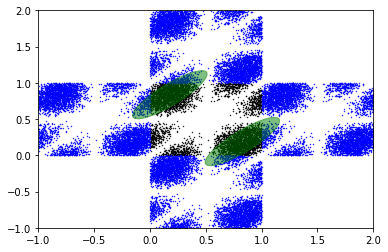

In [32]:
plot_results(X, model2.layers[1].get_weights()[0], model2.layers[1].get_weights()[1])

In [39]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(alpha=alpha, n_clusters=n_clusters,
                                                     dissimilarity=dis,
                                                     trainable={"centers": False, "mixers": False, "cov": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model2.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(-0.05, 1.1)

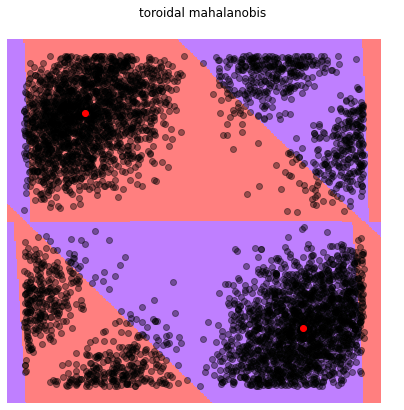

In [40]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal mahalanobis", X, (7, 7), batch_size)
ax.set_xlim([-0.05, 1.1])
ax.set_ylim([-0.05, 1.1])

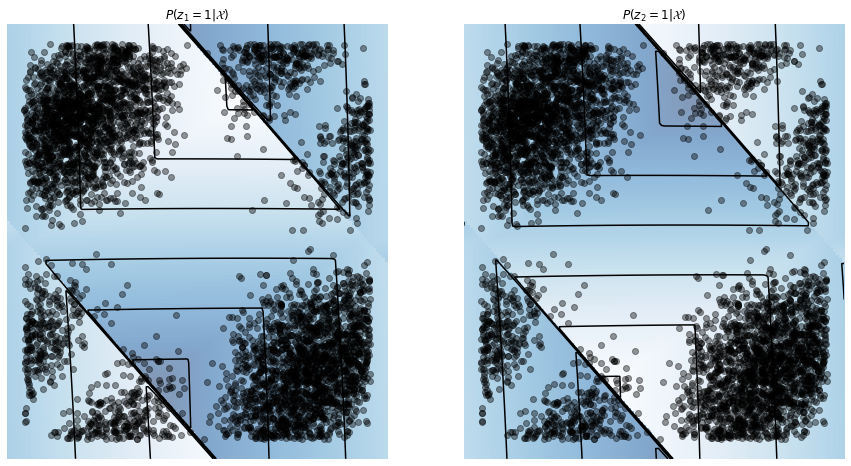

In [41]:
fig, ax = vis_utils.visualize_probas(DMAE_encoder, X, n_clusters, rows=1, cols=2, figsize=(15, 8))

In [ ]:
fig, ax = vis_utils.visualize_distribution(model2, toroidal_mahalanobis_loss, alpha, X, encoder=DMAE_encoder, cov=False, figsize=(10, 10))